In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3a
commitnumber = 5014a19
conc = 0.0004
dv = 0.01
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 620
vmin = 540
w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.55, 1.6, 1.85)]
wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

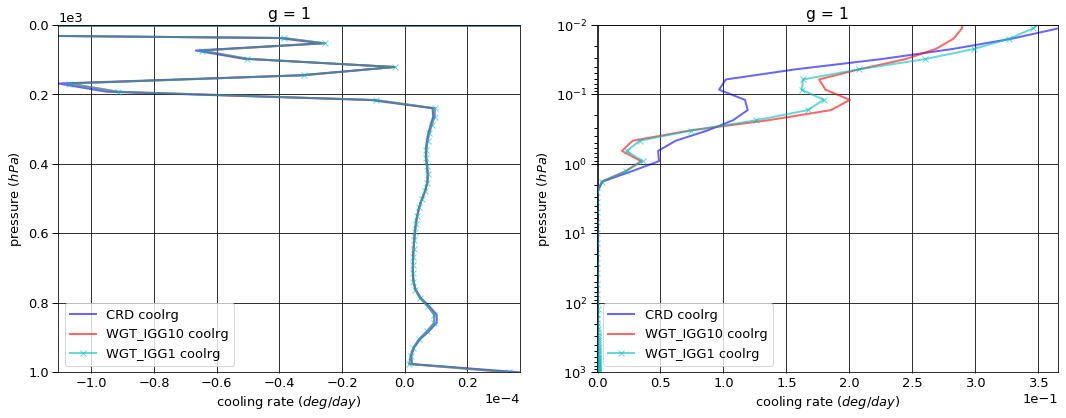

# Figure: cooling rate g-group 2

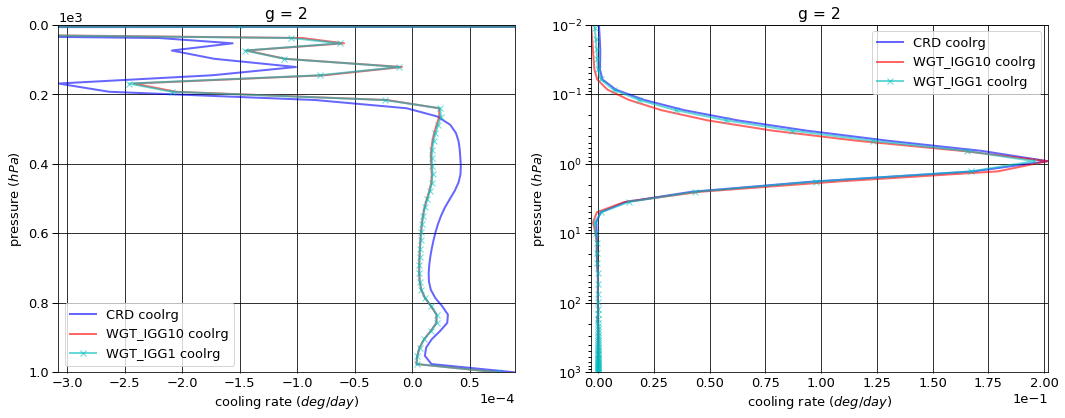

# Figure: cooling rate g-group 3

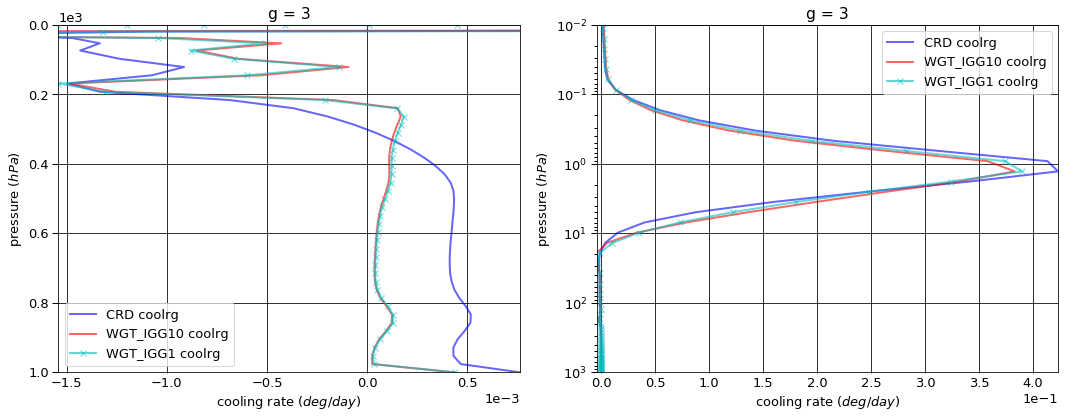

# Figure: cooling rate g-group 4

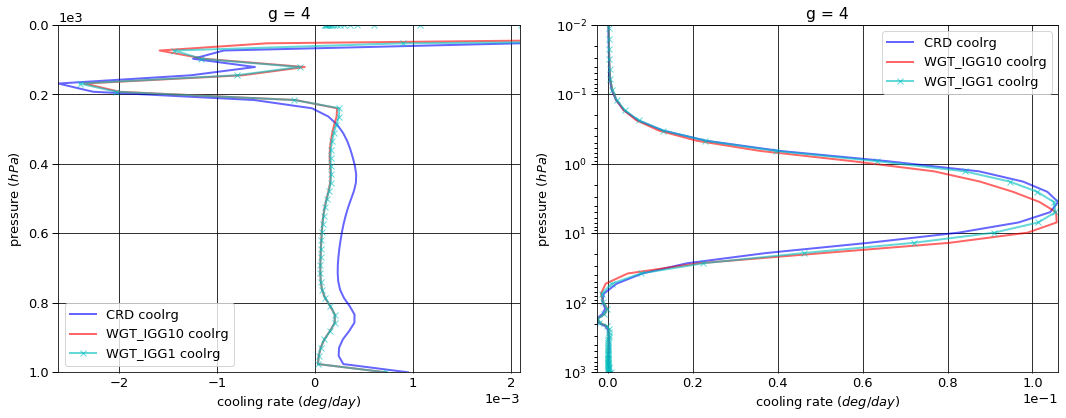

# Figure: cooling rate g-group 5

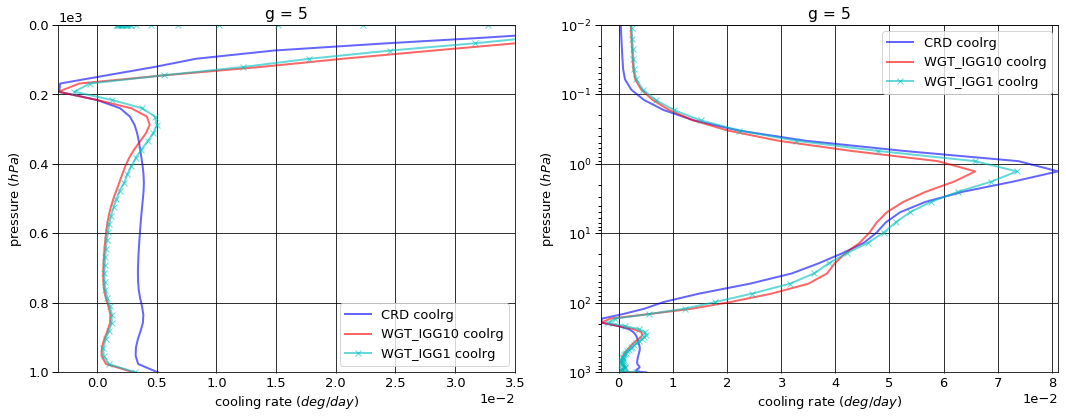

# Figure: cooling rate g-group 6

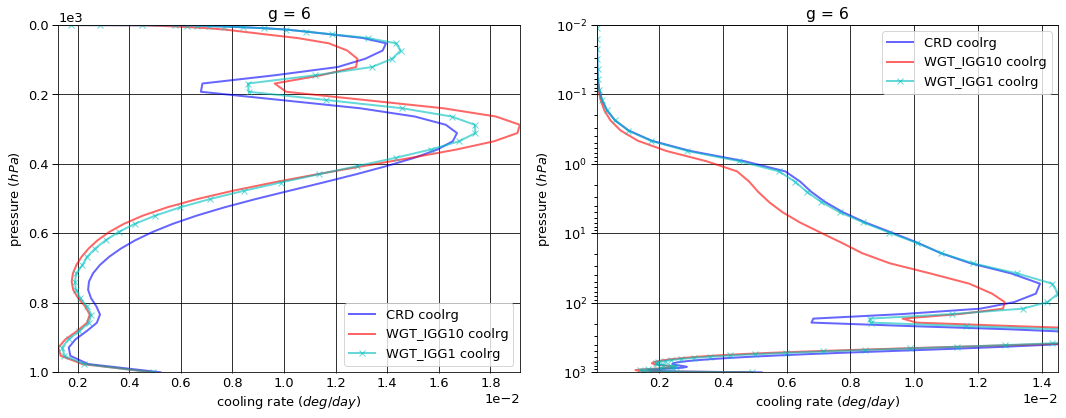

# Figure: cooling rate g-group 7

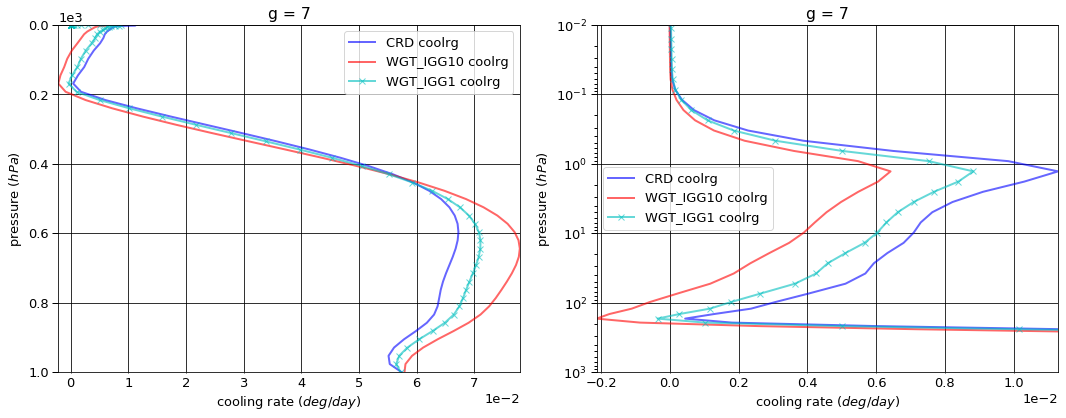

# Figure: cooling rate g-group 8

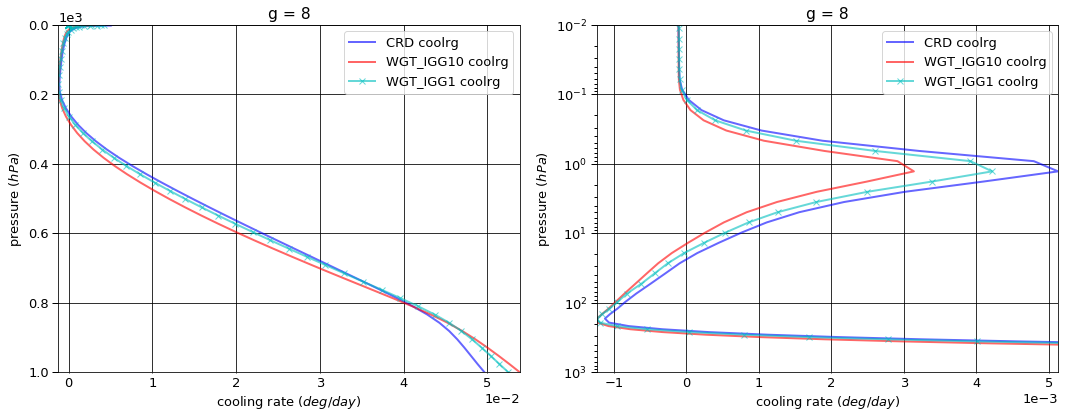

# Figure: cooling rate g-group 9

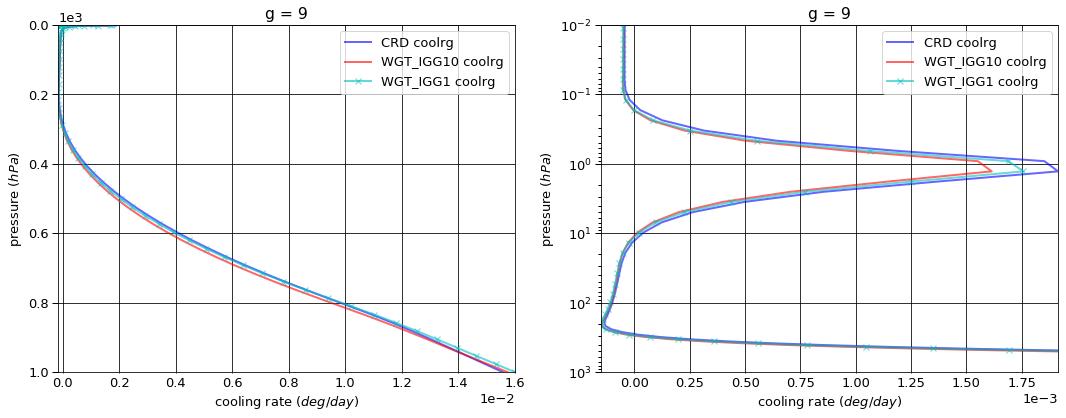

# Figure: cooling rate g-group total

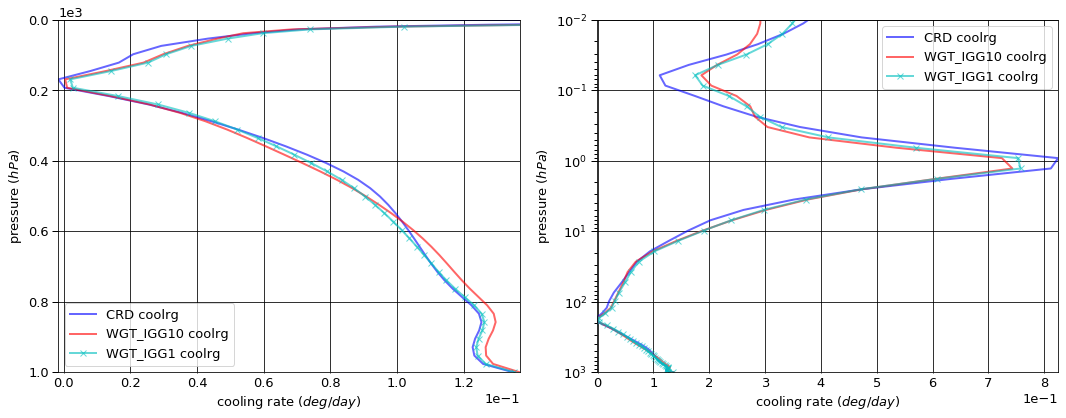

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.010192  0.000000  -0.010192
  1013.0   76     -0.022579  0.022474  -0.000105
2 0.0      1      -0.034579  0.000000  -0.034579
  1013.0   76     -0.049695  0.049400  -0.000294
3 0.0      1      -0.175262  0.000000  -0.175262
  1013.0   76     -0.284882  0.271857  -0.013025
4 0.0      1      -0.226668  0.000000  -0.226668
  1013.0   76     -0.487985  0.482970  -0.005015
5 0.0      1      -0.801746  0.000000  -0.801746
  1013.0   76     -1.696290  1.554795  -0.141496
6 0.0      1      -0.984865  0.000000  -0.984865
  1013.0   76     -2.319760  2.295172  -0.024588
7 0.0      1      -6.510457  0.000000  -6.510457
  1013.0   76     -9.723756  8.436991  -1.286765
8 0.0      1      -7.555236  0.000000  -7.555236
  1013.0   76     -8.249624  2.993398  -5.256227
9 0.0      1     -13.292174  0.000000 -13.292174
  1013.0   76    -13.400837  0.651733 -12.749103


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009370  0.000000  -0.009370
  1013.0   76     -0.021994  0.021902  -0.000092
2 0.0      1      -0.035012  0.000000  -0.035012
  1013.0   76     -0.048508  0.048304  -0.000205
3 0.0      1      -0.174926  0.000000  -0.174926
  1013.0   76     -0.279482  0.278275  -0.001207
4 0.0      1      -0.229960  0.000000  -0.229960
  1013.0   76     -0.476582  0.474579  -0.002004
5 0.0      1      -0.631877  0.000000  -0.631877
  1013.0   76     -1.666735  1.656367  -0.010368
6 0.0      1      -0.955329  0.000000  -0.955329
  1013.0   76     -2.271350  2.250391  -0.020959
7 0.0      1      -6.514754  0.000000  -6.514754
  1013.0   76     -9.565365  8.583071  -0.982294
8 0.0      1      -7.662064  0.000000  -7.662064
  1013.0   76     -8.274121  2.829758  -5.444362
9 0.0      1     -13.526759  0.000000 -13.526759
  1013.0   76    -13.631271  0.628363 -13.002908


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009428  0.000000  -0.009428
  1013.0   76     -0.021994  0.021902  -0.000092
2 0.0      1      -0.034539  0.000000  -0.034539
  1013.0   76     -0.048508  0.048302  -0.000207
3 0.0      1      -0.173290  0.000000  -0.173290
  1013.0   76     -0.279482  0.278229  -0.001253
4 0.0      1      -0.228850  0.000000  -0.228850
  1013.0   76     -0.476582  0.474570  -0.002012
5 0.0      1      -0.641831  0.000000  -0.641831
  1013.0   76     -1.666735  1.654885  -0.011850
6 0.0      1      -0.960939  0.000000  -0.960939
  1013.0   76     -2.271350  2.249297  -0.022054
7 0.0      1      -6.442414  0.000000  -6.442414
  1013.0   76     -9.565365  8.470825  -1.094540
8 0.0      1      -7.593098  0.000000  -7.593098
  1013.0   76     -8.274121  2.985133  -5.288988
9 0.0      1     -13.520966  0.000000 -13.520966
  1013.0   76    -13.631271  0.653633 -12.977638


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000822  0.000000  0.000822
  1013.0   76     0.000585 -0.000572  0.000012
2 0.0      1     -0.000433  0.000000 -0.000433
  1013.0   76     0.001186 -0.001097  0.000090
3 0.0      1      0.000335  0.000000  0.000335
  1013.0   76     0.005400  0.006417  0.011818
4 0.0      1     -0.003292  0.000000 -0.003292
  1013.0   76     0.011403 -0.008391  0.003012
5 0.0      1      0.169870  0.000000  0.169870
  1013.0   76     0.029556  0.101572  0.131128
6 0.0      1      0.029536  0.000000  0.029536
  1013.0   76     0.048410 -0.044781  0.003629
7 0.0      1     -0.004297  0.000000 -0.004297
  1013.0   76     0.158391  0.146080  0.304471
8 0.0      1     -0.106828  0.000000 -0.106828
  1013.0   76    -0.024496 -0.163639 -0.188135
9 0.0      1     -0.234585  0.000000 -0.234585
  1013.0   76    -0.230434 -0.023370 -0.253805


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000764  0.000000  0.000764
  1013.0   76     0.000585 -0.000572  0.000012
2 0.0      1      0.000039  0.000000  0.000039
  1013.0   76     0.001186 -0.001099  0.000088
3 0.0      1      0.001972  0.000000  0.001972
  1013.0   76     0.005400  0.006371  0.011772
4 0.0      1     -0.002182  0.000000 -0.002182
  1013.0   76     0.011403 -0.008400  0.003003
5 0.0      1      0.159916  0.000000  0.159916
  1013.0   76     0.029556  0.100090  0.129646
6 0.0      1      0.023926  0.000000  0.023926
  1013.0   76     0.048410 -0.045875  0.002534
7 0.0      1      0.068043  0.000000  0.068043
  1013.0   76     0.158391  0.033835  0.192225
8 0.0      1     -0.037862  0.000000 -0.037862
  1013.0   76    -0.024496 -0.008265 -0.032761
9 0.0      1     -0.228792  0.000000 -0.228792
  1013.0   76    -0.230434  0.001899 -0.228535

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.418089
  1001.112500 75     0.000037
2 0.000312    1     -0.003614
  1001.112500 75     0.000089
3 0.000312    1     -0.002334
  1001.112500 75     0.000763
4 0.000312    1      0.000064
  1001.112500 75     0.000953
5 0.000312    1     -0.000175
  1001.112500 75     0.005085
6 0.000312    1      0.000023
  1001.112500 75     0.005213
7 0.000312    1     -0.000018
  1001.112500 75     0.057435
8 0.000312    1     -0.000113
  1001.112500 75     0.049663
9 0.000312    1     -0.000041
  1001.112500 75     0.015591


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.238747
  1001.112500 75     0.000033
2 0.000312    1     -0.005525
  1001.112500 75     0.000074
3 0.000312    1     -0.000469
  1001.112500 75     0.000431
4 0.000312    1      0.000114
  1001.112500 75     0.000725
5 0.000312    1      0.001620
  1001.112500 75     0.003054
6 0.000312    1      0.000019
  1001.112500 75     0.004909
7 0.000312    1     -0.000026
  1001.112500 75     0.057905
8 0.000312    1     -0.000105
  1001.112500 75     0.053882
9 0.000312    1     -0.000043
  1001.112500 75     0.015760


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.330048
  1001.112500 75     0.000033
2 0.000312    1     -0.004843
  1001.112500 75     0.000074
3 0.000312    1     -0.001705
  1001.112500 75     0.000439
4 0.000312    1      0.000101
  1001.112500 75     0.000727
5 0.000312    1      0.001667
  1001.112500 75     0.003187
6 0.000312    1      0.000026
  1001.112500 75     0.004915
7 0.000312    1      0.000002
  1001.112500 75     0.057240
8 0.000312    1     -0.000106
  1001.112500 75     0.052501
9 0.000312    1     -0.000045
  1001.112500 75     0.016025


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.179342
  1001.112500 75    -0.000003
2 0.000312    1     -0.001911
  1001.112500 75    -0.000015
3 0.000312    1      0.001865
  1001.112500 75    -0.000331
4 0.000312    1      0.000050
  1001.112500 75    -0.000228
5 0.000312    1      0.001795
  1001.112500 75    -0.002031
6 0.000312    1     -0.000004
  1001.112500 75    -0.000305
7 0.000312    1     -0.000008
  1001.112500 75     0.000470
8 0.000312    1      0.000008
  1001.112500 75     0.004219
9 0.000312    1     -0.000002
  1001.112500 75     0.000169


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.088041
  1001.112500 75    -0.000003
2 0.000312    1     -0.001229
  1001.112500 75    -0.000015
3 0.000312    1      0.000628
  1001.112500 75    -0.000323
4 0.000312    1      0.000036
  1001.112500 75    -0.000226
5 0.000312    1      0.001842
  1001.112500 75    -0.001897
6 0.000312    1      0.000003
  1001.112500 75    -0.000298
7 0.000312    1      0.000020
  1001.112500 75    -0.000195
8 0.000312    1      0.000006
  1001.112500 75     0.002838
9 0.000312    1     -0.000004
  1001.112500 75     0.000434

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.591179,0.00000,-29.591179
1013.0,76,-36.235408,16.75879,-19.476618



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.740051,0.000000,-29.740051
1013.0,76,-36.235409,16.771009,-19.464399



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.605354,0.000000,-29.605354
1013.0,76,-36.235409,16.836775,-19.398633



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.488725e-01,0.000000,-0.148872
1013.0,76,-1.930000e-07,0.012219,0.012218



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.417559e-02,0.000000,-0.014176
1013.0,76,-1.930000e-07,0.077985,0.077984


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.411881
1001.112500,75,0.134828



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.234332
1001.112500,75,0.136774



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.325143
1001.112500,75,0.135143



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.177549
1001.112500,75,0.001946



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.086738
1001.112500,75,0.000315


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000625,0.000607
2,0.001375,0.001339
3,0.007875,0.007713
4,0.013500,0.013152
5,0.046875,0.045997
6,0.064125,0.062683
7,0.268500,0.263978
8,0.227375,0.228344
9,0.369750,0.376186


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.333865e-19
2,2.151599e-20
3,1.983568e-21
4,1.777292e-21
5,1.650053e-22
6,7.272858e-22
7,6.811052e-23
8,6.378569e-24
9,1.012133e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.333865e-19,NaN,0.000625,0.000607,0.000625,0.000607,1.0
2,2.151599e-20,0.092190,0.001375,0.001339,0.002000,0.001946,1.0
3,1.983568e-21,0.092190,0.007875,0.007713,0.009875,0.009659,1.0
4,1.777292e-21,0.896007,0.013500,0.013152,0.023375,0.022811,10.0
5,1.650053e-22,0.092841,0.046875,0.045997,0.070250,0.068808,10.0
6,7.272858e-22,4.407650,0.064125,0.062683,0.134375,0.131492,500.0
7,6.811052e-23,0.093650,0.268500,0.263978,0.402875,0.395470,500.0
8,6.378569e-24,0.093650,0.227375,0.228344,0.630250,0.623814,500.0
9,1.012133e-25,0.015868,0.369750,0.376186,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
